### Импорт необходимых библиотек

In [1]:
import re # Для обработки текстов
from gensim.models import Word2Vec # Готовая word2vec для обучения и использования
from tqdm import tqdm # Для отслеживания прогресса различных задач
import pandas as pd # Для считывания информации о датасете
from torch.optim.lr_scheduler import ReduceLROnPlateau # Для обучения нейронной сети
from torch.optim import Adam # Оптимизатор нейронной сети
from IPython.display import clear_output # Для отчистки графика во время обучения НС
from sklearn.metrics import classification_report # Для вывода финальных метрик
import matplotlib.pyplot as plt # Для визуализации
import numpy as np # Для математических операций
from sklearn.model_selection import train_test_split # для создания тестовой выборки
import torchvision.models as models # Для импортирования моедлей pytorch
import torch # Для работы с глебоким обучением
from torch import nn #
from torch.utils.data import Dataset, DataLoader # Для удобного создания датасетов и лоадеров
from sklearn.utils import resample # Для сэмплирования

d:\mlp\machinelearning\venv\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'D:\mlp\MachineLearning\venv\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


### Чтение данных

In [2]:
data = pd.read_csv('Pre_Post_Questions.csv', sep=',', encoding='latin1')

In [3]:
data.isna().sum()

id             0
question       0
item_name    123
label        304
dtype: int64

In [4]:
data = data[~data.label.isna()]

In [5]:
data.iloc[:, 3] = pd.Series((data.label=='Pre').astype(int))

In [6]:
data_X, data_y = data.question, data.label

### Препроцессинг данных

In [7]:
class Preprocessor:
    def __init__(self, texts):
        self.texts_v1 = list(texts)
        self.texts_v2 = []
        self.main()
    def main(self):
        new_texts = []
        for sentence in tqdm(self.texts_v1):
            temp = sentence.lower()
            temp = re.sub('\t', ' ', temp)
            temp = re.sub('[!]', ' voskznak ', temp)
            temp = re.sub('[?]', ' questznack ', temp)
            temp = re.sub('[^a-zA-Z ]', ' ', temp)
            temp = re.sub("[^a-zA-Z0-9\'\"]", ' ', temp)
            temp = re.sub(r'\s+', ' ', temp)
            temp = temp.strip()
            new_texts.append(temp)
        self.texts_v2 = new_texts

In [8]:
pr = Preprocessor(data_X)

100%|██████████| 231600/231600 [00:02<00:00, 90950.53it/s]


In [9]:
data_X = pr.texts_v2

In [10]:
data_X

['are boots cold reliable questznack',
 'is the main body rubber or plastic questznack',
 'do you know the thread pitch count for the tang questznack',
 'the item ordered came tarnished and my son needed it by wednesday voskznak voskznak voskznak is there any way you can send a replacement as soon as possible questznack questznack voskznak voskznak',
 'i purchased these and now they look weird with my stock headlights what headlights would match these questznack',
 'how long after placing order until us delivery questznack',
 'wich one would you recommend to go with torque pro obd for a audi a i need to know',
 'will this fit a stern monopoly machine questznack',
 'what year were these knives made questznack',
 'is the power cord detachable questznack',
 'anyone have their soda stream bottle turn into a fountain after adding the lemonade syrup to it questznack mine acted like a mentos coke experiment',
 'how can i be a prime members',
 'will this work for a jeep wrangler',
 'what ages 

### Деление на трейн и тест

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.25)

### Обучение w2v

In [11]:
w2v_model = Word2Vec(min_count=3, window=5, vector_size=100, sg=1)
w2v_model.build_vocab(X_train)
w2v_model.train(X_train, total_examples=len(X_train), epochs=w2v_model.epochs)

(10993866, 63355665)

### Прогоняем все тексты через w2v и делаем одинаковой размерности

In [12]:
def final_transform(X_train, X_test, emb_size):
    full_train_texts = []
    full_test_texts = []

    for text in X_train:
        sentence = []
        q = np.ones(emb_size)
        for word in text:
            if word in w2v_model.wv.key_to_index:
                sentence.append(w2v_model.wv[word])
            else:
                sentence.append(q)
        full_train_texts.append(sentence)

    for text in X_test:
        sentence = []
        q = np.ones(emb_size)
        for word in text:
            if word in w2v_model.wv.key_to_index:
                sentence.append(w2v_model.wv[word])
            else:
                sentence.append(q)
        full_test_texts.append(sentence)

    max_length = np.array([len(x) for x in full_train_texts]).mean().astype(int)

    format_train_text = []
    for text in full_train_texts:
        temp = np.zeros((max_length, emb_size))
        if len(text)!=0:
            temp[:min(max_length, len(text))] = text[:min(max_length, len(text))]
        format_train_text.append(temp)


    format_test_text = []
    for text in full_test_texts:
        temp = np.zeros((max_length, emb_size))
        if len(text)!=0:
            temp[:min(max_length, len(text))] = text[:min(max_length, len(text))]
        format_test_text.append(temp)

    format_test_text = np.array(format_test_text)
    format_train_text = np.array(format_train_text)
    return(format_train_text, format_test_text)

In [13]:
X_train, X_test = final_transform(X_train, X_test, 100)

### Датасет

In [14]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.tensor(y.tolist())

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, item):
        return(self.X[item], self.y[item])

### Реализация LSTM с промежуточным attention

In [15]:
class MyLSTM(nn.Module):
    def __init__(self, emb_size):
        super(MyLSTM, self).__init__()
        self.attention_weight = nn.Linear(emb_size//2, 1)
        self.LSTM = nn.LSTM(emb_size, emb_size//2, batch_first=True)
        self.seq = nn.Sequential(
            nn.Linear(emb_size//2, emb_size//4),
            nn.Linear(emb_size//4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x =  self.LSTM(x)[0] ### LSTM
        w = self.attention_weight(x).squeeze() ### взвешиваем слова
        w = nn.Softmax(dim=-1)(w).unsqueeze(1) ### взвешиваем слова так, чтобы веса были в диапазоне от 0 до 1
        x = torch.matmul(w, x).squeeze() ### Нужно чтобы взвесить слова
        x = self.seq(x).squeeze()
        return x

### loss функция для обучения НС

In [30]:
def loss_function(pred, true):
    loss = nn.BCELoss()
    return loss(pred, true)

### Функция обучения НС

In [52]:
all_train_losses = []
all_test_losses = []
def train_model(model,
                num_epochs,
                loss_function,
                optimizer,
                scheduler,
                train_dataloader,
                test_dataloader):
    for epoch in range(num_epochs):
        train_loss = 0
        test_loss = 0
        model.train(True)
        print(f'epoch_number is {epoch}. Train')
        for (X, y) in tqdm(train_dataloader):
            model.zero_grad()
            X = X.to(device)
            y = y.to(device)
            preds = model.forward(X)
            loss = loss_function(preds, y.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().item() / (len(train_dataloader))
        model.train(False)
        model.eval()
        print(f'epoch_number is {epoch}. Test')
        for (X, y) in tqdm(test_dataloader):
            X = X.to(device)
            y = y.to(device)
            preds = model.forward(X)
            loss = loss_function(preds, y.float())
            test_loss += loss.detach().item() / (len(test_dataloader))
        scheduler.step(test_loss)
        clear_output()
        all_train_losses.append(train_loss)
        all_test_losses.append(test_loss)
        print('loss train', train_loss)
        print('loss test', test_loss)
        plt.figure(figsize = (10, 6))
        plt.plot(all_train_losses, label = 'Train loss', color = 'blue')
        plt.plot(all_test_losses, label = 'Val loss', color = 'orange')
        plt.legend()
        plt.ylabel('Loss')
        plt.grid()
        plt.show()

### Обучение нейронной сети

In [53]:
batch_size = 1024
train_dataset = CustomDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataset = CustomDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [54]:
model = MyLSTM(100)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
num_epochs = 50
lr = 1e-4
optimizer = Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer=optimizer, factor=0.5, patience=2, threshold=1e-3)

loss train 0.5909776451319634
loss test 0.5901240068569519


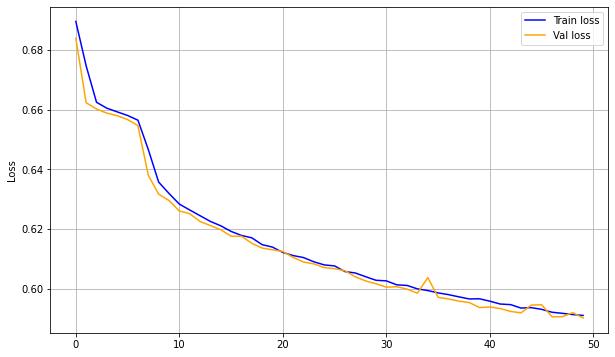

In [55]:
train_model(model, num_epochs, loss_function, optimizer, scheduler, train_dataloader, test_dataloader)

### Получение предсказаний на тесте

In [56]:
preds = []
real = []
for x, y in tqdm(test_dataloader):
    with torch.no_grad():
        preds.append(model.forward(x.to(device)).detach().cpu().numpy())
        real.append(y.numpy())


100%|██████████| 57/57 [00:01<00:00, 41.24it/s]


In [57]:
final_preds = (np.concatenate(preds)>0.5).astype(int)
real = np.concatenate(real)

In [58]:
print(classification_report(real, final_preds))

              precision    recall  f1-score   support

           0       0.69      0.50      0.58     24446
           1       0.69      0.83      0.76     33454

    accuracy                           0.69     57900
   macro avg       0.69      0.67      0.67     57900
weighted avg       0.69      0.69      0.68     57900



### Вывод
Результат мог быть лучше, если бы обучение происходило с использованием self-attention или использовании трансформеров ИЛИ если увеличить количество слов, которое может быть обработано нейронной сетью,нако это сильно уменьшает скорость обучения